# 0. Initialize common libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# 1. Loading and inspecting data

In [2]:
# Load example dataset (same as Bethany Baumann used for data visualization 
# https://notebooks.ai/Beth1126/pda-python-dataframes-and-graphs-webinar-2020-54351877)
data = sns.load_dataset('mpg')

In [3]:
data.head() # dataset contains information on cars

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


# 2. Data cleaning

## 2.1. Column to predict

In [4]:
# Let us find the columns, which we want to predict and format it
feature_to_predict = 'mpg'  # miles per gallon
readout = data[[feature_to_predict]].astype(float)

## 2.2. Features

## 2.2.1. Numeric features

In [5]:
ordinal_features = [
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model_year'
]

features_ordinal = data[ordinal_features].astype(float)

In [6]:
if any(features_ordinal.isnull()):
    print('At least some features have absent values')

At least some features have absent values


In [7]:
# Make educated guesses on missing values (impute)
from sklearn.impute import SimpleImputer   # note that sklearn will soon get better ones
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_values = imputer.fit_transform(features_ordinal.values)

In [8]:
# For consistency, store data in original format (DataFrame)
features_ordinal = pd.DataFrame(
    index=features_ordinal.index,
    data=imputed_values,
    columns=features_ordinal.columns
)

## 2.2.2. Nominal  features

In [9]:
nominal_features = [
    'origin'
]

In [10]:
from sklearn.preprocessing import OneHotEncoder 
onehotencoder = OneHotEncoder() 

one_hot_feature = onehotencoder.fit_transform(
    data[nominal_features]).toarray()

In [11]:
one_hot_feature

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [12]:
onehotencoder.categories_

[array(['europe', 'japan', 'usa'], dtype=object)]

In [13]:
features_nominal = pd.DataFrame(
    index=data.index, 
    columns=onehotencoder.categories_,
    data=one_hot_feature

)

In [14]:
features_nominal.head(3)

,europe,japan,usa
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0


## 2.2.3. Combine ordinal and nominal features

In [15]:
features = pd.concat(
    [features_ordinal, features_nominal],
    axis='columns'
)

In [16]:
features.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,"(europe,)","(japan,)","(usa,)"
0,8.0,307.0,130.0,3504.0,12.0,70.0,0.0,0.0,1.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,0.0,0.0,1.0
2,8.0,318.0,150.0,3436.0,11.0,70.0,0.0,0.0,1.0
3,8.0,304.0,150.0,3433.0,12.0,70.0,0.0,0.0,1.0
4,8.0,302.0,140.0,3449.0,10.5,70.0,0.0,0.0,1.0


# 3. Machine Learning

## 3.1. Split training and testing set

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# per informal convention we will use
#  X to designate our features and
#  y as the value that should be predicted
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    readout, 
    test_size=0.33)

## 3.2. Initialize a Gradient Boosting Model
Gradient Boosting will essentially perform two steps: First it will create a decision based model on the data. Second it will create a model of its own error. Together this means that 1) gradient boosting models can accomodate very distinct non-linear relationships between features and the entity to be predicted; 2) they are quite robust against being supplied too many (non-informative) features

In [19]:
from sklearn import ensemble
gradient_booster = ensemble.GradientBoostingRegressor()
gradient_booster.fit(X_train, y_train) # train with a subset of our data

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

## 3.3. Test performance of our model

In [20]:
y_predicted = gradient_booster.predict(X_test)

Text(0, 0.5, 'Predicted miles per gallon')

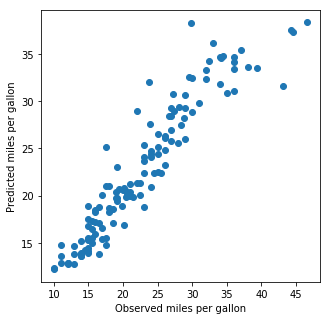

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_predicted)
plt.xlabel('Observed miles per gallon')
plt.ylabel('Predicted miles per gallon')

In [22]:
from scipy.stats import spearmanr

In [23]:
spearmanr(y_test, y_predicted)

SpearmanrResult(correlation=0.9559594972106207, pvalue=4.489234746558822e-71)

## 3.4. Inspect models
To understand, which features drive the prediction.

In [24]:
gradient_booster.feature_importances_

array([0.00541008, 0.3792603 , 0.10535436, 0.29445748, 0.01638485,
       0.19139826, 0.00270457, 0.0011627 , 0.00386741])

In [25]:
features.head(2)

,cylinders,displacement,horsepower,weight,acceleration,model_year,"(europe,)","(japan,)","(usa,)"
0,8.0,307.0,130.0,3504.0,12.0,70.0,0.0,0.0,1.0
1,8.0,350.0,165.0,3693.0,11.5,70.0,0.0,0.0,1.0


In [26]:
pd.Series(
    index=features.columns, 
    data=gradient_booster.feature_importances_).sort_values(ascending=False)

displacement    0.379260
weight          0.294457
model_year      0.191398
horsepower      0.105354
acceleration    0.016385
cylinders       0.005410
(usa,)          0.003867
(europe,)       0.002705
(japan,)        0.001163
dtype: float64

# (optional) 4. Iterate to test robustness
if running above multiple times, you will notice that some of the numbers (correlation between predicted and measured; and features importances) will change. This is largely because you will have different training and test sets. 

## 4.1. Run multiple iterations, and gather statistics

In [27]:
iterations = 300

In [28]:
correlations = []

feature_importances = pd.DataFrame(
    index=features.columns,
    columns=range(iterations),
    data=np.nan

)

In [29]:
for j in range(iterations):

    X_train, X_test, y_train, y_test = train_test_split(
        features, readout, test_size=0.33)
    
    gradient_booster.fit(X_train, y_train.values.ravel())
    y_predicted = gradient_booster.predict(X_test)

    correlations.append(spearmanr(y_test, y_predicted)[0])
    feature_importances.loc[:, j] = gradient_booster.feature_importances_

## 4.2. Inspect

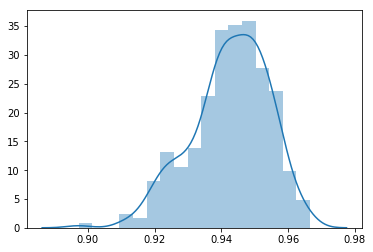

In [30]:
# Distribution of predicted correlations
sns.distplot(correlations)

In [31]:
# Sanity check: are predictions better than any single correlation?
data.corr('spearman').loc['mpg', :]

mpg             1.000000
cylinders      -0.821864
displacement   -0.855692
horsepower     -0.853616
weight         -0.874947
acceleration    0.438677
model_year      0.573469
Name: mpg, dtype: float64

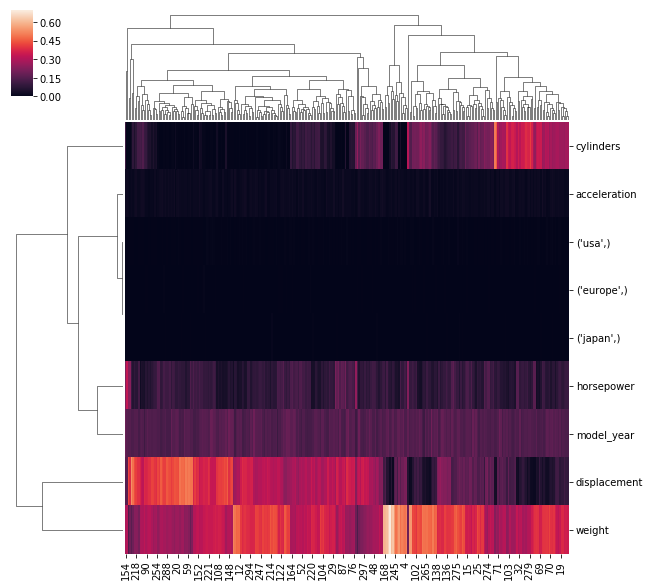

In [32]:
# Feature importances
sns.clustermap(feature_importances)